In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

def get_data(path):
    df = pd.read_csv(path, header=None)
    data = df.values[:,:len(df.columns)-1]
    targets = df.values[:,len(df.columns)-1:]
    return data, targets

def get_and_split_data(path):
    df = pd.read_csv(path, header=None)
    data = df.values[:,:len(df.columns)-1]
    targets = df.values[:,len(df.columns)-1:]
    train_data, test_data, train_targets, test_targets = train_test_split(
        data, targets, test_size = 0.5, random_state=5)
    return train_data, test_data, np.ravel(train_targets), np.ravel(test_targets)

def run_knn(n, train_data, test_data, train_targets, test_targets, ret_pred=False):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(train_data, train_targets)
    pred = knn.predict(test_data)
    if ret_pred:
        return metrics.accuracy_score(test_targets, pred), pred
    else:
        return metrics.accuracy_score(test_targets, pred)

def run_logreg(train_data, test_data, train_targets, test_targets, ret_pred=False):
    logreg = LogisticRegression()
    logreg.fit(train_data, train_targets)
    pred = logreg.predict(test_data)
    if ret_pred:
        return metrics.accuracy_score(test_targets, pred), pred
    else:
        return metrics.accuracy_score(test_targets, pred)
    
def run_models(path, verbose=False, plots=False):
    model_accuracy = dict()
    train_data, test_data, train_targets, test_targets = get_and_split_data(path)
    
    """kNN"""
    k_range = np.arange(1,6,1)
    knn_scores = []
    for k in k_range:
        knn_scores.append(run_knn(k, train_data, test_data, train_targets, test_targets))
    knn_accuracy, pred = run_knn(np.argmax(knn_scores)+1, train_data, test_data, train_targets, test_targets, True)
    model_accuracy['kNN'] = knn_accuracy
    
    """kNN w/ gridsearch"""
    # With cross-validation
    # knn = KNeighborsClassifier()
    # param_grid = dict(n_neighbors = k_range)
    # grid = GridSearchCV(knn, param_grid, cv=2, scoring='accuracy')
    # grid.fit(train_data, train_targets)
    # pred = grid.predict(test_data)
    # print(metrics.accuracy_score(test_targets, pred))
    
    """logreg"""
    model_accuracy['logreg'] = run_logreg(train_data, test_data, train_targets, test_targets)
    
    """null"""
    model_accuracy['null'] = max(test_targets.mean(), 1- test_targets.mean())
    
    if verbose:
        for key, value in model_accuracy.items():
            print("{:20} {}".format(key + ' accuracy:', value))
    if plots:
        # kNN plot
        plt.plot(k_range, knn_scores)
        plt.xticks(k_range)
        plt.xlabel('Value of k for kNN')
        plt.ylabel('Classification accuracy')
        plt.axis([1, 5, 0, 1])
        plt.title('Accuracy of kNN')

        # confusion matrix
        labels = ['Control', 'MRSA']
        cm = metrics.confusion_matrix(test_targets, pred)
        print("Confusion matrix:\n{}".format(cm))
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix of the classifier\n')
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
    return model_accuracy
    

### Test \#1: Using only 120 minute data

kNN accuracy:        0.6842105263157895
logreg accuracy:     0.47368421052631576
null accuracy:       0.5789473684210527
Confusion matrix:
[[ 2  6]
 [ 0 11]]


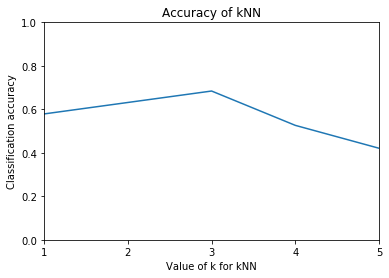

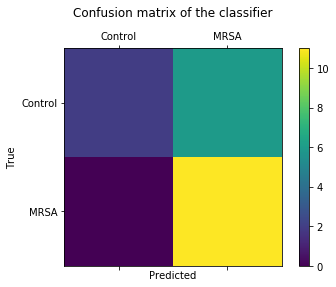

In [2]:
results = run_models('data/120min.csv', True, True)

### Test \#2: Using only 420 minute data

kNN accuracy:        1.0
logreg accuracy:     1.0
null accuracy:       0.5789473684210527
Confusion matrix:
[[ 8  0]
 [ 0 11]]


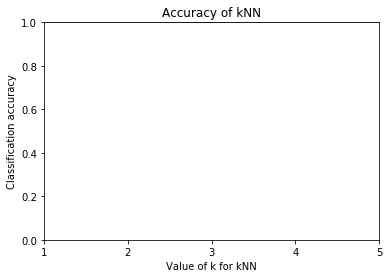

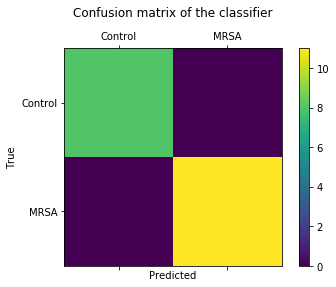

In [3]:
results = run_models('data/420min.csv', True, True)

### Time vs. classification accuracy

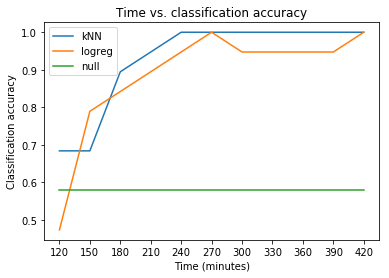

In [4]:
times = [120, 150, 180,
         210, 240, 270,
         300, 330, 360,
         390, 420]

all_results = dict()

for time in times:
    results = run_models('data/'+str(time)+'min.csv', verbose=False, plots=False)
    for key, value in results.items():
        if key in all_results:
            all_results[key].append(value)
        else:
            all_results[key] = [value]

legend = []
for key in all_results:
    plt.plot(times, all_results[key])
    legend.append(str(key))
plt.xticks(times)
plt.legend(legend, loc='upper left')
plt.xlabel('Time (minutes)')
plt.ylabel('Classification accuracy')
plt.title('Time vs. classification accuracy')
plt.show()

### Notes
- Two machine learning algorithms are used: k-nearest neighbor (kNN) and logistic regression (logreg).
- Null accuracy refers to the classification accuracy by simply choosing the most frequent result (i.e., MRSA)
- The confusion matrix shows true negatives (top left), false negatives (top right), false positives (bottom left), and true positives (bottom right).
- Test \#1 uses only data from 120 minutes in; test \#2 uses only data from 420 minutes in (previous times not included).
- The time vs. classification accuracy plot tells us that kNN can predict with 100% accuracy at 240 minutes.